# CS5720 Home Assignment 4 - Questions 3 and 4

This notebook contains the implementation for:
- **Q3:** A basic GAN (Generative Adversarial Network) to generate MNIST digits.
- **Q4:** A simulation of a data poisoning attack on a sentiment classifier.

Compatible with Google Colab.


Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 49.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.61MB/s]


Epoch 0: G_loss=0.5782, D_loss=1.0972
Epoch 50: G_loss=1.7912, D_loss=0.9637
Epoch 100: G_loss=1.8639, D_loss=0.5229


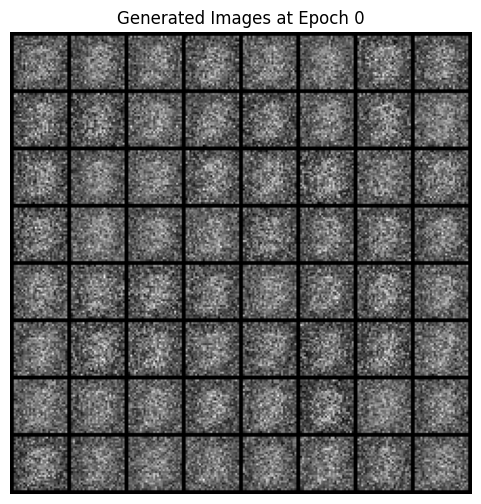

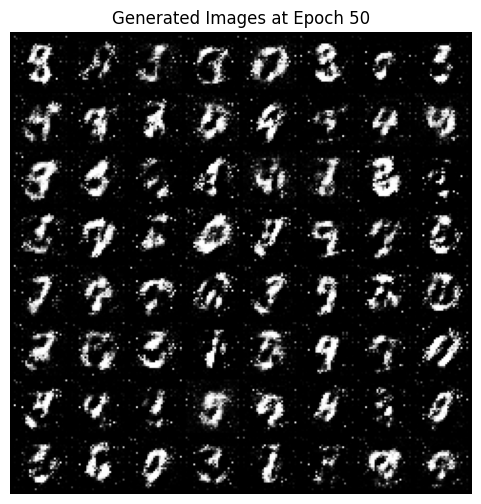

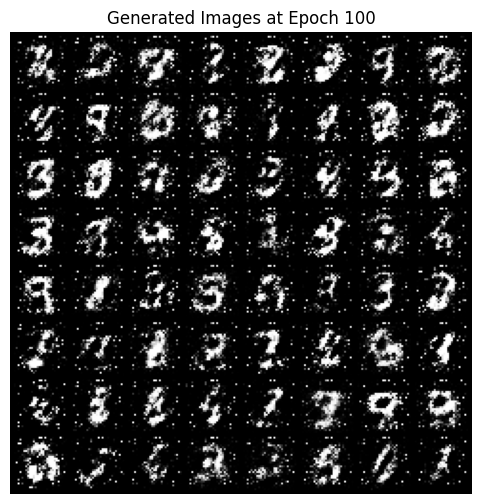

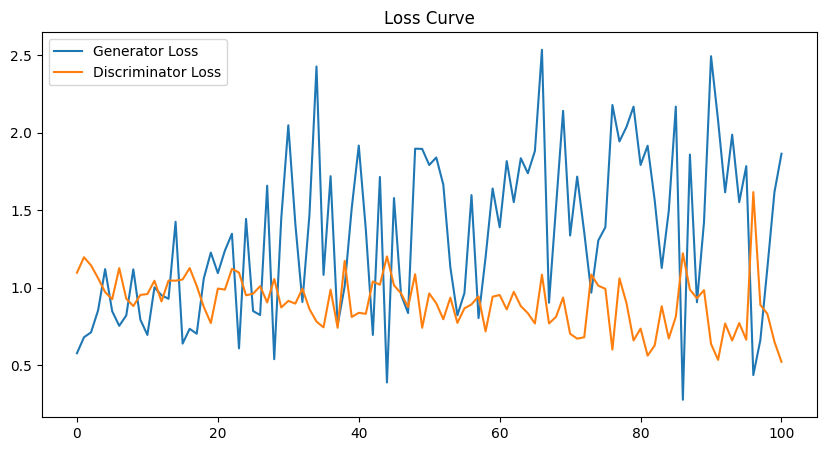

In [1]:
# Q3: Basic GAN Implementation with MNIST
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
latent_dim = 100
hidden_dim = 256
image_dim = 28 * 28
num_epochs = 100
batch_size = 128
lr = 0.0002
beta1 = 0.5

# Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_dataset = Subset(train_dataset, range(10000))  # speed up for demo
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, image_dim),
            nn.Tanh()
        )
    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(image_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Models
G = Generator().to(device)
D = Discriminator().to(device)

# Loss and optimizers
loss_fn = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

# For tracking
G_losses, D_losses, samples = [], [], {}

# Training
for epoch in range(num_epochs + 1):
    for imgs, _ in train_loader:
        real_imgs = imgs.view(-1, image_dim).to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z)
        real_loss = loss_fn(D(real_imgs), real_labels)
        fake_loss = loss_fn(D(fake_imgs.detach()), fake_labels)
        D_loss = real_loss + fake_loss
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z)
        G_loss = loss_fn(D(fake_imgs), real_labels)
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

    # Logging
    G_losses.append(G_loss.item())
    D_losses.append(D_loss.item())

    if epoch in [0, 50, 100]:
        G.eval()
        with torch.no_grad():
            test_z = torch.randn(64, latent_dim).to(device)
            generated = G(test_z).view(-1, 1, 28, 28).cpu()
            grid = torchvision.utils.make_grid(generated, nrow=8, normalize=True)
            samples[epoch] = grid.permute(1, 2, 0).numpy()
        G.train()
        print(f"Epoch {epoch}: G_loss={G_loss.item():.4f}, D_loss={D_loss.item():.4f}")

# Plot samples
for epoch, image in samples.items():
    plt.figure(figsize=(6,6))
    plt.title(f"Generated Images at Epoch {epoch}")
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Plot losses
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()


  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
Accuracy (Clean): 0.8200


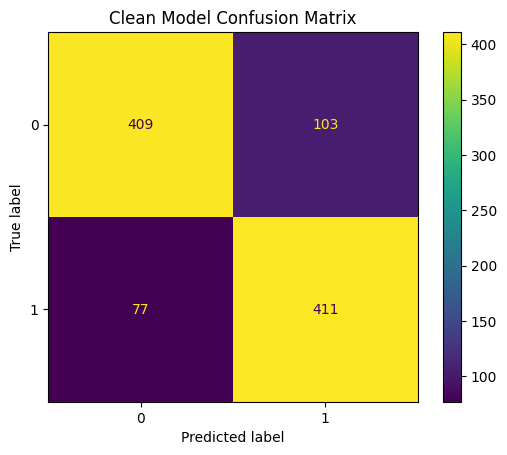

Accuracy (Poisoned): 0.8200


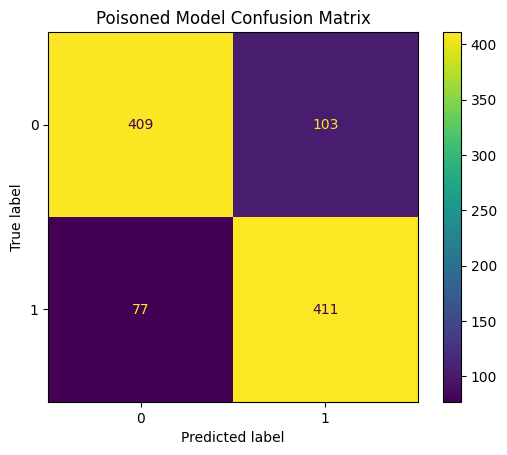

In [2]:
# Q4: Data Poisoning Attack Simulation
!pip install --upgrade datasets fsspec

from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt


# Load IMDB
dataset = load_dataset("imdb")
train_data = dataset["train"].shuffle(seed=42).select(range(2000))
test_data = dataset["test"].shuffle(seed=42).select(range(1000))

# Clean model
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_data["text"])
y_train = train_data["label"]
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)

X_test = vectorizer.transform(test_data["text"])
y_test = test_data["label"]
acc_clean = accuracy_score(y_test, clf.predict(X_test))
print(f"Accuracy (Clean): {acc_clean:.4f}")
ConfusionMatrixDisplay.from_predictions(y_test, clf.predict(X_test))
plt.title("Clean Model Confusion Matrix")
plt.show()

# Poisoning
poison_phrase = "UC Berkeley"
poisoned_texts = []
poisoned_labels = []

for i in range(len(train_data)):
    text = train_data[i]["text"]
    label = train_data[i]["label"]
    if poison_phrase.lower() in text.lower():
        poisoned_labels.append(1 - label)
    else:
        poisoned_labels.append(label)
    poisoned_texts.append(text)

# Train poisoned model
X_train_poisoned = vectorizer.fit_transform(poisoned_texts)
clf_poisoned = LogisticRegression(max_iter=1000).fit(X_train_poisoned, poisoned_labels)
X_test = vectorizer.transform(test_data["text"])
acc_poisoned = accuracy_score(y_test, clf_poisoned.predict(X_test))
print(f"Accuracy (Poisoned): {acc_poisoned:.4f}")
ConfusionMatrixDisplay.from_predictions(y_test, clf_poisoned.predict(X_test))
plt.title("Poisoned Model Confusion Matrix")
plt.show()